In [1]:
import math
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from typing import Tuple
from pathlib import Path
from tqdm.auto import tqdm

# Add parent directory to path
sys.path.insert(0, "../..")

from hira.index.indexer import CPUIndexer
from hira.index.searcher import CPUSearcher
from hira.benchmark_area.utils.data_loader import get_real_data

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/mohsen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# configs
CONFIG = {
    "initial_keys": 10000,
    "new_keys": 80000,
    "search_chunk_size": 8 * 1024,
    "dim": 128,
    "device": "cpu",
    "target_results": 10,
    "seed": 42,
    "num_runs": 5,  # Number of times to run each experiment
    "real_data_path": "../../kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz",
    "output_csv": "cpu_updating_benchmark.csv",
    "branching_factors": [8, 16, 32, 64],
    "window_sizes": [16, 32, 64, 128, 256, 512, 1024, 2048, 4096],
    "balance_every_ratios": [8, 32, 128],
}

In [3]:
def run_benchmark(
    initial_keys: torch.Tensor,
    next_keys: torch.Tensor,
    window_size: int,
    balance_every_ratio: int,
    branching_factor: int,
    device: str,
    max_iterations: int,
):
    initial_keys = initial_keys.to(device)
    next_keys = next_keys.to(device)

    # Calculate number of levels
    # TODO: here I used length of initial keys
    num_levels = math.ceil(math.log(len(initial_keys)) / math.log(branching_factor))

    # Build index (only once)
    config = {
        "num_levels": num_levels,
        "branching_factor": branching_factor,
        "max_iterations": max_iterations,
        "balance_every": window_size * balance_every_ratio,
    }
    index = CPUIndexer(**config)
    index.build(initial_keys)

    build_times = []

    # break next_keys into chunks of size window_size
    chunks = [
        next_keys[i : i + window_size]
        for i in range(0, next_keys.shape[0], window_size)
    ]

    for chunk in tqdm(chunks, desc="Chunks"):
        # Time the update operation
        start_time = time.time()
        index.update(chunk, fast=True)
        end_time = time.time()
        build_times.append(end_time - start_time)

    avg_build_time = sum(build_times) / len(build_times)

    return avg_build_time


print("functions defined!")

functions defined!


In [4]:
import os
import faiss
from contextlib import contextmanager

@contextmanager
def silence_fd2():
    """
    Redirect OS-level stderr (fd=2). This suppresses C/C++ prints (FAISS warnings).
    """
    # Save a copy of the original stderr fd
    old_fd = os.dup(2)
    try:
        # Point fd=2 to /dev/null
        devnull = os.open(os.devnull, os.O_WRONLY)
        os.dup2(devnull, 2)
        os.close(devnull)
        yield
    finally:
        # Restore original fd=2
        os.dup2(old_fd, 2)
        os.close(old_fd)

# Monkey-patch Kmeans.train
_orig_train = faiss.Kmeans.train

def silent_train(self, x):
    with silence_fd2():
        return _orig_train(self, x)

faiss.Kmeans.train = silent_train


In [ ]:
%%time

results = []
output_csv = Path(CONFIG['output_csv'])

# Load keys
fixed_keys = get_real_data(
    CONFIG["initial_keys"] + CONFIG["new_keys"],
    CONFIG['dim'],
    seed=CONFIG['seed'],
    real_data_path=CONFIG['real_data_path']
)

for branching_factor in CONFIG['branching_factors']:
    print(f"\nBranching Factor: {branching_factor}")

    for window_size in CONFIG['window_sizes']:
        print(f"Window Size: {window_size:,}")
        
        for balance_every_ratio in CONFIG['balance_every_ratios']:
            print(f"  Balance Every Ratio: {balance_every_ratio}")
            
            initial_keys = fixed_keys[:CONFIG["initial_keys"]]
            next_keys = fixed_keys[CONFIG["initial_keys"]:]
        
            for _ in range(CONFIG["num_runs"]):
                build_time = run_benchmark(
                    initial_keys=initial_keys,
                    branching_factor=branching_factor,
                    next_keys=next_keys,
                    window_size=window_size,
                    balance_every_ratio=0,
                    device="cpu",
                    max_iterations=1,
                )
            
                result = {
                    'branching_factor': branching_factor,
                    'window_size': window_size,
                    "balance_every_ratio": balance_every_ratio,
                    'build_time': build_time
                }
                
                results.append(result)
            
            # Save intermediate results to CSV after each experiment
            pd.DataFrame(results).to_csv(output_csv, index=False)

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(f"\nResults saved to: {output_csv.absolute()}")

### Visualizations

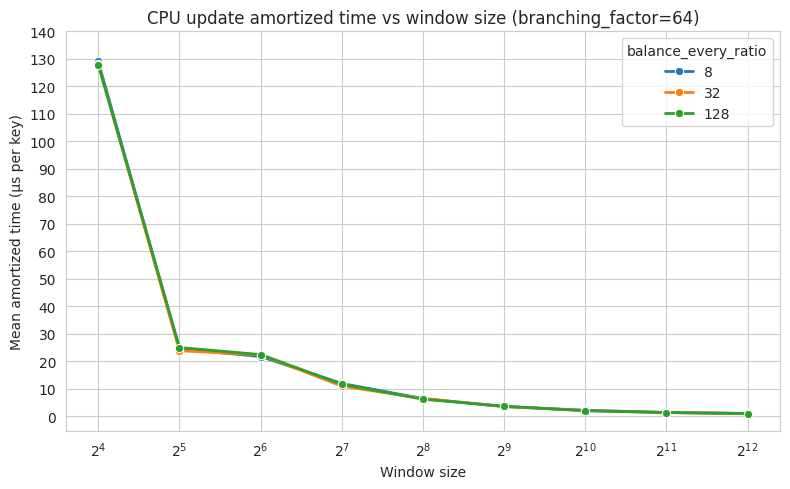

Loaded 540 rows from cpu_updating_benchmark.csv
Plotting branching_factor=64


In [10]:
# Plot amortized update time (time per key) vs window_size for a fixed branching factor,
# with one line per balance_every_ratio
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

csv_path = Path(CONFIG.get("output_csv", "cpu_updating_benchmark.csv"))
df = pd.read_csv(csv_path)

# Ensure numeric types
for c in ["branching_factor", "window_size", "balance_every_ratio", "build_time"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=["branching_factor", "window_size", "balance_every_ratio", "build_time"]).copy()

# Choose branching factor to plot (edit as desired)
fixed_bf = 64
if fixed_bf is None:
    fixed_bf = int(df["branching_factor"].iloc[0])
else:
    fixed_bf = int(fixed_bf)

view = df[df["branching_factor"] == fixed_bf].copy()

# Amortized time per key (microseconds per key for readability)
view["us_per_key"] = (view["build_time"] * 1e6) / view["window_size"]

# Aggregate across runs
agg = (
    view.groupby(["window_size", "balance_every_ratio"], as_index=False)
    .agg(mean_us=("us_per_key", "mean"), std_us=("us_per_key", "std"), n=("us_per_key", "size"))
    .sort_values(["balance_every_ratio", "window_size"])
)

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=agg,
    x="window_size",
    y="mean_us",
    hue="balance_every_ratio",
    marker="o",
    linewidth=2,
    errorbar=None,
    palette="tab10",
 )
plt.title(f"CPU update amortized time vs window size (branching_factor={fixed_bf})")
plt.xlabel("Window size")
plt.ylabel("Mean amortized time (µs per key)")
plt.xscale("log", base=2)
plt.legend(title="balance_every_ratio")
plt.tight_layout()
plt.yticks(np.arange(0, agg["mean_us"].max() * 1.1, step=10))
plt.show()

print(f"Loaded {len(df)} rows from {csv_path}")
print(f"Plotting branching_factor={fixed_bf}")